In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import requests
import sys

import tensorflow as tf

tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

#import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt

print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.5.0


In [2]:
#model requires python 3.6 
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
import pandas as pd

df_train, df_test = pd.read_csv('atis_intents_train.csv'), pd.read_csv('atis_intents_test.csv')
df_train.columns, df_test.columns = ['intent', 'snippet'], ['intent', 'snippet']

df_train.head()

,intent,snippet
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


In [5]:
df_train.intent.value_counts(), df_train.intent.value_counts(normalize=True)

(atis_flight            3665
 atis_airfare            423
 atis_ground_service     255
 atis_airline            157
 atis_abbreviation       147
 atis_aircraft            81
 atis_flight_time         54
 atis_quantity            51
 Name: intent, dtype: int64,
 atis_flight            0.758328
 atis_airfare           0.087523
 atis_ground_service    0.052762
 atis_airline           0.032485
 atis_abbreviation      0.030416
 atis_aircraft          0.016760
 atis_flight_time       0.011173
 atis_quantity          0.010552
 Name: intent, dtype: float64)

In [6]:
train_data = df_train.snippet.values
train_labels = df_train.intent.values
test_data = df_test.snippet.values
test_labels = df_test.intent.values          

print('Training Dataset Size: {}'.format(len(train_data)))
#print('Train Targets: {}'.format(len(train_labels)))
print('Testing Dataset Size: {}'.format(len(test_data)))
#print('Test Targets: {}'.format(len(test_labels)))
print('Dataset Type: {}'.format(type(train_data)))

Training Dataset Size: 4833
Testing Dataset Size: 799
Dataset Type: <class 'numpy.ndarray'>


In [7]:
# Maximum sentence length
MAX_LENGTH = 10

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(list(df_train.snippet) + list(df_test.snippet))
VOCAB_SIZE = tokenizer.document_count
tokenized_requests_train = tokenizer.texts_to_sequences(df_train.snippet)
tokenized_requests_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_requests_train, 
                                                                    maxlen=MAX_LENGTH,padding='post')
tokenized_requests_test = tokenizer.texts_to_sequences(df_test.snippet)
tokenized_requests_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_requests_test, 
                                                                    maxlen=MAX_LENGTH,padding='post')

In [8]:
print('Sample Request: {}'.format(train_data[2]))
print('Sample Token: {}'.format(tokenized_requests_train[2]))
print('Sample Target: {}'.format(train_labels[2]))

Sample Request:  cheapest airfare from tacoma to orlando
Sample Token: [ 53 260   2 164   1  95   0   0   0   0]
Sample Target: atis_airfare


In [9]:
target_train_df = pd.get_dummies(train_labels)
target_test_df = pd.get_dummies(test_labels)
target_train_df.head()

,atis_abbreviation,atis_aircraft,atis_airfare,atis_airline,atis_flight,atis_flight_time,atis_ground_service,atis_quantity
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [10]:
ATIS_Labels = list(target_train_df.columns)

with open("ATIS_Labels_List.txt", "w") as output:
    output.write(str(ATIS_Labels))

In [11]:
print(*ATIS_Labels, sep = '\n')

atis_abbreviation
atis_aircraft
atis_airfare
atis_airline
atis_flight
atis_flight_time
atis_ground_service
atis_quantity


In [12]:
tokenized_targets_train = target_train_df.values
tokenized_targets_test = target_test_df.values
print('Dataset Type: {}'.format(type(tokenized_targets_train)))

Dataset Type: <class 'numpy.ndarray'>


In [13]:
# Train/Val Split
prop = 0.8
N = len(tokenized_requests_train)
x_train = tokenized_requests_train[:int(N*prop)]
y_train = tokenized_targets_train[:int(N*prop)]

x_val = tokenized_requests_train[int(N*prop):]
y_val = tokenized_targets_train[int(N*prop):]

x_test = tokenized_requests_test
y_test = tokenized_targets_test

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,25))
model.add((tf.keras.layers.LSTM(10, return_sequences=True)))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dense(8, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 25)          140800    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 10)          1440      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 143,168
Trainable params: 143,168
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [17]:
history = model.fit(
    x_train, y_train, batch_size=32, epochs=15, validation_data=(x_val, y_val)
)

Epoch 1/15
121/121 [==============================] - 5s 15ms/step - loss: 0.4622 - accuracy: 0.4555 - val_loss: 0.2734 - val_accuracy: 0.7497
Epoch 2/15
121/121 [==============================] - 1s 9ms/step - loss: 0.2318 - accuracy: 0.7605 - val_loss: 0.2160 - val_accuracy: 0.7497
Epoch 3/15
121/121 [==============================] - 1s 8ms/step - loss: 0.1992 - accuracy: 0.7605 - val_loss: 0.1878 - val_accuracy: 0.7497
Epoch 4/15
121/121 [==============================] - 1s 8ms/step - loss: 0.1629 - accuracy: 0.7700 - val_loss: 0.1544 - val_accuracy: 0.7673
Epoch 5/15
121/121 [==============================] - 1s 8ms/step - loss: 0.1372 - accuracy: 0.8145 - val_loss: 0.1346 - val_accuracy: 0.8252
Epoch 6/15
121/121 [==============================] - 1s 9ms/step - loss: 0.1252 - accuracy: 0.8228 - val_loss: 0.1258 - val_accuracy: 0.8232
Epoch 7/15
121/121 [==============================] - 1s 9ms/step - loss: 0.1169 - accuracy: 0.8259 - val_loss: 0.1207 - val_accuracy: 0.8273
Epoch

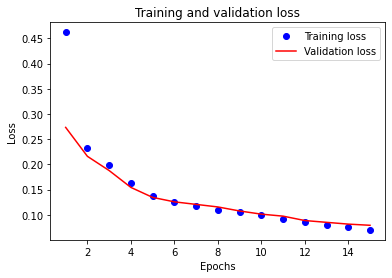

In [18]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

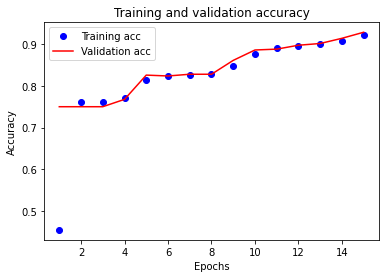

In [19]:

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
print(x_test.shape,y_test.shape)

(799, 10) (799, 8)


In [21]:
print('Sample Request: {}'.format(test_data[2]))
print('Sample Request Token: {}'.format(x_test[2]))
print('Sample Target: {}'.format(test_labels[2]))
print('Sample Target Token: {}'.format(y_test[2]))

Sample Request:  i would like a flight traveling one way from phoenix to san diego on april first
Sample Request Token: [ 69  72   2  92   1  11 101   5 186  43]
Sample Target: atis_flight
Sample Target Token: [0 0 0 0 1 0 0 0]


In [22]:
y_pred = model.predict(x_test)

In [23]:
y_pred.shape

(799, 8)

In [24]:
y_pred[2,:]

array([0.00200467, 0.0029074 , 0.02371102, 0.00296811, 0.96173483,
       0.00222053, 0.00126797, 0.0031855 ], dtype=float32)

In [25]:
# evaluate custom query

input_txt = "please return the price range for flights from chicago to new york on january third"
tokenized_input = tokenizer.texts_to_sequences(input_txt)
padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized_input, 
                                             maxlen=MAX_LENGTH,padding='post')

In [26]:
raw_output = model.predict(padded)[0]
sum(raw_output)

0.9999999925494194

In [27]:
output = {ATIS_Labels[i]: raw_output[i] for i in range(len(ATIS_Labels))}
output

{'atis_abbreviation': 0.21912031,
 'atis_aircraft': 0.22837397,
 'atis_airfare': 0.19532706,
 'atis_airline': 0.02103704,
 'atis_flight': 0.19127429,
 'atis_flight_time': 0.016828075,
 'atis_ground_service': 0.11397696,
 'atis_quantity': 0.014062287}

In [28]:
max_value = max(output.values())
max_key = [k for k,v in output.items() if v == max_value]
print(max_key, max_value)

['atis_aircraft'] 0.22837397


In [29]:
## Save Model using .h5 format
model.save('lstm-model-ATIS_INTENT.h5')
## Load model with the following command:
# tf.keras.models.load_model('lstm-model-ATIS_INTENT.h5')

In [30]:
import io, json
## Save tokenizer using .json format
tokenizer_json = tokenizer.to_json()
with io.open('lstm-tokenizer-ATIS_INTENT.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
## load tokenizer with the following commands:
#with open(tokenizer_path) as f:
#    data = json.load(f)
#    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)